# ADA Homework 2 - Data from the Web

In [1]:
%matplotlib inline

In [2]:
import requests
import json
import re
import difflib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

In [3]:
MAX = 200

## 1. 200 QS Top Universities from www.topuniversities.com 

In [4]:
NB_BEST = 200
QS_URL = "https://www.topuniversities.com/"
QS_RANK_URL = "https://www.topuniversities.com/university-rankings/world-university-rankings/2018"
QS_DATA_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"

In [5]:
QS_data_req = requests.get(QS_DATA_URL)
QS_data = QS_data_req.json()

In [6]:
QS_ranking = pd.DataFrame(columns = ["title", "rank_display", "country", "region", "score"])

def extract_number(tag):
    wrapper = uni_soup.find("div", class_=tag)
    if wrapper:
        string = wrapper.find("div", class_="number").text[1:]
        return int(re.sub("[^0-9^.]", "", string))
    else:
        return np.nan

for i in range(200):
    df_i = pd.DataFrame.from_dict(QS_data["data"][i], orient='index').T
    df_i = df_i.drop(["nid", "stars", "guide", "cc", "logo", "core_id", "url"], axis=1)
    
    #print(df_i.title)
    #if df_i.title[0] in QS_ranking.title:
    #    continue
    
    uni_url = QS_URL + QS_data["data"][i]["url"]
    uni_request = requests.get(uni_url)
    uni_page_body = uni_request.text
    uni_soup = BeautifulSoup(uni_page_body, 'html.parser')
    
    df_i['rank_display'] = int(re.sub("[^0-9^.]", "", str(df_i.rank_display)))
    df_i["total_students"] = extract_number("total student")
    df_i["international_students"] = extract_number("total inter")
    df_i["faculty_members"] = extract_number("total faculty")
    df_i["inter_faculty_members"] = extract_number("inter faculty")
    df_i['faculty/students'] = df_i.total_students / df_i.faculty_members
    df_i['inter/students'] = df_i.international_students / df_i.total_students
    
    QS_ranking = QS_ranking.append(df_i)
    
    
QS_ranking = QS_ranking.add_suffix("_QS")
QS_ranking = QS_ranking.rename(columns={'title_QS':'name',
                                        'faculty_members_QS': 'total_faculty_QS',
                                        'inter_faculty_members_QS': 'inter_faculty_QS',
                                        'international_students_QS': 'inter_students_QS',
                                        'rank_display_QS': 'rank_QS'})
QS_ranking = QS_ranking.set_index("name")

In [7]:
QS_ranking.head(200)
QS_ranking[QS_ranking.index == 'Cornell University']

,country_QS,faculty/students_QS,total_faculty_QS,inter/students_QS,inter_faculty_QS,inter_students_QS,rank_QS,region_QS,score_QS,total_students_QS
name,,,,,,,,,,
Cornell University,United States,8.058867,2718.0,0.247033,970.0,5411.0,14,North America,90.7,21904.0


## 1a,b: Ratios

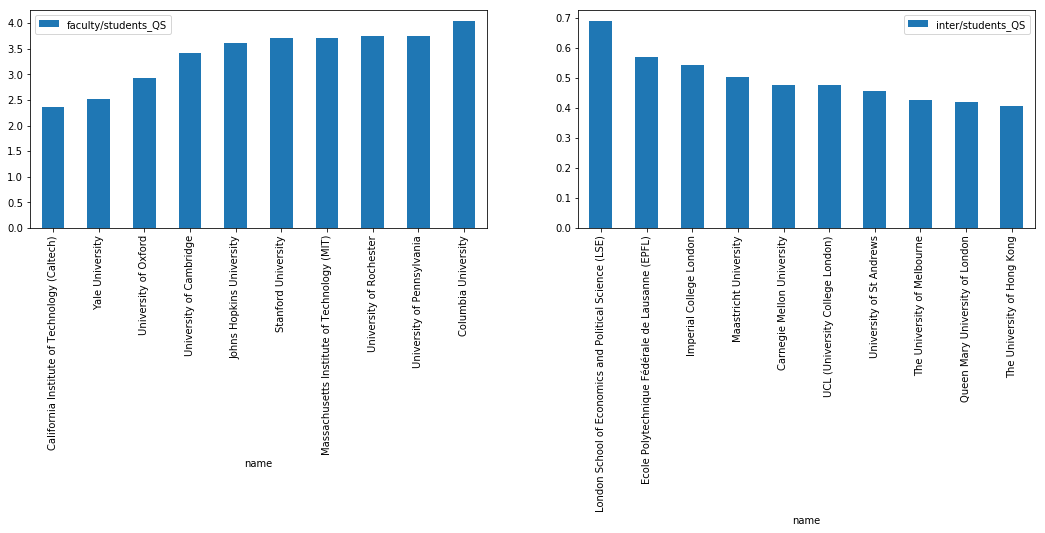

In [8]:
fig = plt.figure(figsize=(18, 4))

ax = fig.add_subplot(121)
QS_ranking[['faculty/students_QS']] \
    .sort_values(by='faculty/students_QS', ascending=True) \
    .head(10) \
    .plot(kind='bar', ax=ax)

ax = fig.add_subplot(122)
QS_ranking[['inter/students_QS']] \
    .sort_values(by='inter/students_QS', ascending=False) \
    .head(10) \
    .plot(kind='bar', ax=ax)

## 1c,d: Ratios aggregated by country and region

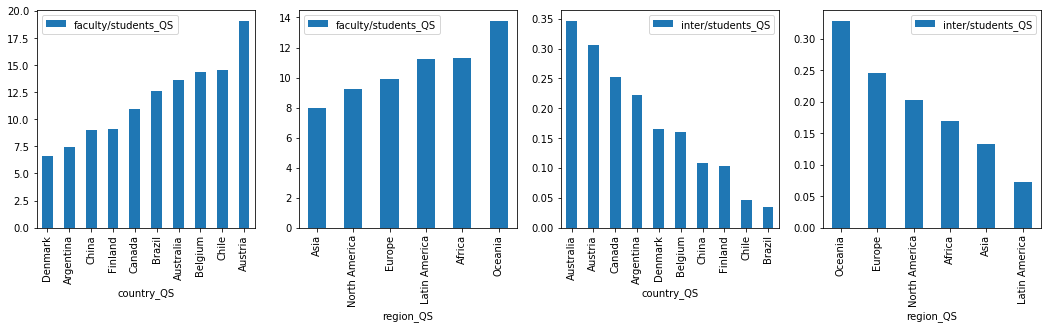

In [9]:
fig = plt.figure(figsize=(18, 4))

ax = fig.add_subplot(141)
QS_ranking.groupby(['country_QS']) \
    .agg({'faculty/students_QS': np.mean}) \
    .head(10) \
    .sort_values(by='faculty/students_QS', ascending=True).plot(kind='bar', ax=ax)
    
ax = fig.add_subplot(142)
QS_ranking.groupby(['region_QS']) \
    .agg({'faculty/students_QS': np.mean}) \
    .sort_values(by='faculty/students_QS', ascending=True).plot(kind='bar', ax=ax)

ax = fig.add_subplot(143)
QS_ranking.groupby(['country_QS']) \
    .agg({'inter/students_QS': np.mean}) \
    .head(10) \
    .sort_values(by='inter/students_QS', ascending=False).plot(kind='bar', ax=ax)

ax = plt.subplot(144)
QS_ranking.groupby(['region_QS']) \
    .agg({'inter/students_QS': np.mean}) \
    .sort_values(by='inter/students_QS', ascending=False).plot(kind='bar', ax=ax)

## 2. 200 TH Top Universities from www.timeshighereducation.com

In [10]:
TH_RANK_URL = "http://timeshighereducation.com/world-university-rankings/2018/world-ranking"
TH_DATA_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

In [11]:
TH_data_req = requests.get(TH_DATA_URL)
TH_data = TH_data_req.json()

In [12]:
TH_ranking = pd.DataFrame()

for i in range(200):
    df_i = pd.DataFrame.from_dict(TH_data["data"][i], orient='index').T
    drop_cols = df_i.columns.difference(["name", "rank", "scores_overall", "location", 'region'])
    df_i = df_i.drop(drop_cols, axis=1)
    
    if len(QS_ranking[QS_ranking.country_QS == TH_data['data'][i]['location']].region_QS) > 1:
        df_i['region'] = QS_ranking[QS_ranking.country_QS == TH_data['data'][i]['location']].region_QS[1]
    
    df_i["total_students"] = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_number_students"]))
    percentage_intl = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_pc_intl_students"]))
    df_i["international_students"] = int(df_i.total_students * percentage_intl / 100)
    df_i['rank'] = int(re.sub("[^0-9^.]", "", TH_data["data"][i]["rank"]))
    df_i['faculty/students'] = float(re.sub("[^0-9^.]", "", TH_data["data"][i]["stats_student_staff_ratio"]))
    df_i['inter/students'] = df_i.international_students / df_i.total_students
    
    TH_ranking = TH_ranking.append(df_i)
    
TH_ranking = TH_ranking.add_suffix("_TH")
TH_ranking = TH_ranking.rename(columns = {'name_TH': 'name',
                                          'location_TH': 'country_TH',
                                          'scores_overall_TH': 'score_TH',
                                          'international_students_TH': 'inter_students_TH'})
TH_ranking = TH_ranking.set_index("name")

In [13]:
TH_ranking.head(200)
TH_ranking[TH_ranking.index == 'Delft University of Technology']

,faculty/students_TH,inter/students_TH,inter_students_TH,country_TH,rank_TH,region_TH,score_TH,total_students_TH
name,,,,,,,,
Delft University of Technology,19.6,0.269977,4605,Netherlands,63,Europe,67.3,17057


## 2a,b: Ratios

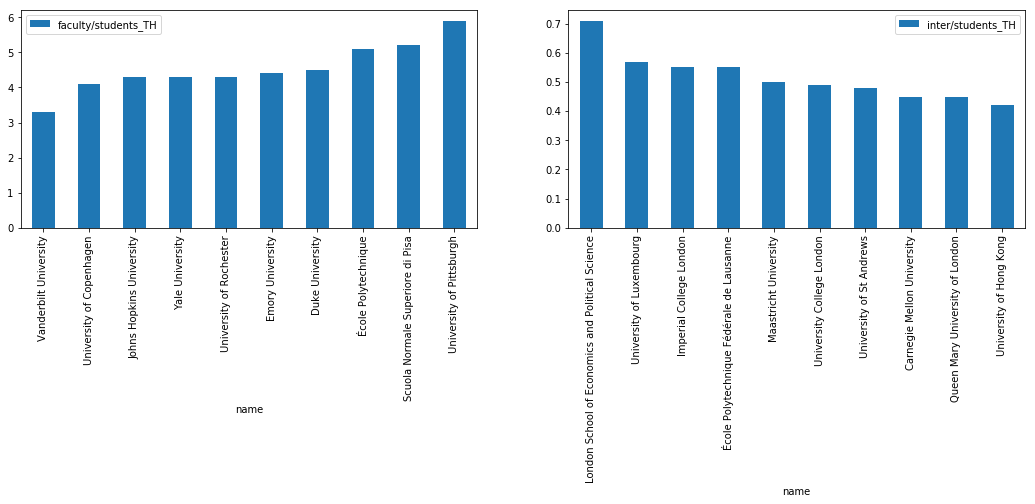

In [14]:
fig = plt.figure(figsize=(18, 4))

ax = fig.add_subplot(121)
TH_ranking[['faculty/students_TH']] \
    .sort_values(by='faculty/students_TH', ascending=True) \
    .head(10) \
    .plot(kind='bar', ax=ax)

ax = fig.add_subplot(122)
TH_ranking[['inter/students_TH']] \
    .sort_values(by='inter/students_TH', ascending=False) \
    .head(10) \
    .plot(kind='bar', ax=ax)

## 1c,d: Ratios aggregated by country and region

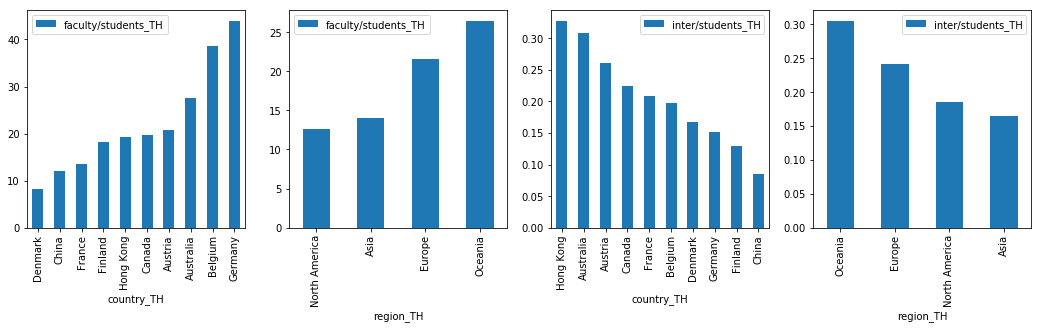

In [15]:
fig = plt.figure(figsize=(18, 4))

ax = fig.add_subplot(141)
TH_ranking.groupby(['country_TH']) \
    .agg({'faculty/students_TH': np.mean}) \
    .head(10) \
    .sort_values(by='faculty/students_TH', ascending=True).plot(kind='bar', ax=ax)
    
ax = fig.add_subplot(142)
TH_ranking.groupby(['region_TH']) \
    .agg({'faculty/students_TH': np.mean}) \
    .sort_values(by='faculty/students_TH', ascending=True).plot(kind='bar', ax=ax)

ax = fig.add_subplot(143)
TH_ranking.groupby(['country_TH']) \
    .agg({'inter/students_TH': np.mean}) \
    .head(10) \
    .sort_values(by='inter/students_TH', ascending=False).plot(kind='bar', ax=ax)

ax = plt.subplot(144)
TH_ranking.groupby(['region_TH']) \
    .agg({'inter/students_TH': np.mean}) \
    .sort_values(by='inter/students_TH', ascending=False).plot(kind='bar', ax=ax)

# DISCUSSION TODO

In [18]:
def match_up(x, indexes_of_b, indexes_of_a):
    matches_in_b = difflib.get_close_matches(x, indexes_of_b)
    if matches_in_b:
        matches_in_a = difflib.get_close_matches(matches_in_b[0], indexes_of_a)
        if (matches_in_a[0] == x):
            return matches_in_b[0]
    return x
    

gg = QS_ranking.copy()
gg.index = gg.index.map(lambda x: match_up(x, TH_ranking.index, QS_ranking.index))

merged = gg.join(TH_ranking, how='outer')
merged.head(100)

,country_QS,faculty/students_QS,total_faculty_QS,inter/students_QS,inter_faculty_QS,inter_students_QS,rank_QS,region_QS,score_QS,total_students_QS,faculty/students_TH,inter/students_TH,inter_students_TH,country_TH,rank_TH,region_TH,score_TH,total_students_TH
name,,,,,,,,,,,,,,,,,,
Aalto University,Finland,9.663484,1257.0,0.150737,370.0,1831.0,137,Europe,56,12147.0,20.2,0.199937,2548.0,Finland,190.0,Europe,52.7,12744.0
Aarhus University,Denmark,11.323834,2316.0,0.143445,602.0,3762.0,119,Europe,59.3,26226.0,14.3,0.119998,3020.0,Denmark,109.0,Europe,59.4,25167.0
Albert-Ludwigs-Universitaet Freiburg,Germany,11.807731,1966.0,0.167873,413.0,3897.0,171,Europe,50.8,23214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alma Mater Studiorum - University of Bologna,Italy,21.203679,2990.0,0.066168,153.0,4195.0,188,Europe,49.1,63399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.1,0.189994,8450.0,United States,126.0,North America,58.1,44475.0
Australian National University,Australia,9.026250,1600.0,0.384365,927.0,5551.0,20,Oceania,87.1,14442.0,19.3,0.349994,5595.0,Australia,48.0,Oceania,71.6,15986.0
Autonomous University of Barcelona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.9,0.159986,5169.0,Spain,147.0,Europe,56.2,32309.0
Boston University,United States,8.128603,3157.0,0.274375,379.0,7041.0,81,North America,67.2,25662.0,8.6,0.249990,6208.0,United States,70.0,North America,65.4,24833.0
Brown University,United States,7.099770,1303.0,0.197276,379.0,1825.0,53,North America,76.5,9251.0,10.7,0.199933,1779.0,United States,50.0,North America,70.8,8898.0
